## Analysis of an effect observed in a paper by Keogh and Lin

In 2005, Eamonn Keogh and Jessica Lin published a (widely cited) paper titled "Clustering of Time Series Subsequences is Meaningless:
Implications for Previous and Future Research" (available at http://www.cs.ucr.edu/~eamonn/meaningless.pdf -- much thanks to the authors for putting their work online)

The paper deals with the then-common practice of dealing with time-series data by first cutting the data into overlapping windows, and then running k-means (or another pre-deep-learning clustering algorithm) on the windowed data slices.

It finds, among other things, that the resulting clusters aren't stable between multiple clustering runs, and that common algorithms using this step work nearly as well when the clusters are replaced by clusters derived from irrelevant data-sets.

The paper claims that the clusters resulting from this step, when run on real-world-data, produce cluster representatives that visually resemble sine waves.  This raised some questions in my mind which I set out to explore here.

# My understanding of the algorithm the authors study

I believe that the windowed clustering method is equivalent to

1. Let the original time series be $\{t_n | 0 \leq n < N \}$
2. Let the $i$th slice be $S_i = \{t_m | i \leq m < i+k\}$ where $k$ is the window width
3. Clustering is run on slices $S_0$ through $S_{N-k}$
4. Clustering is performed by a simple k-means algorithm

# Unanswered questions

The original Keogh and Lin paper treats the question of why this algorithm results in "sine waves" as an unanswered question.  It also doesn't go into detail about whether the frequency of the resulting sine waves depends on the number of clusters, or whether it better reflects underlying frequency characteristics of the clustered data, or properties of the window size.

# Present-day impact

I am not terribly familiar with the state-of-the-art on time-series analysis, but I suspect that the modern equivalent to this windowed clustering technique would be to first run a convolutional sparse-autoencoding neural network over the time series, and use the hidden-layer of *that* output in the place where the cluster identifiers would have been used in previous work.  I suspect that if one digs deeply enough one will find that the signal slices matched by the hidden layer in such an approach might also display instability, and might also exhibit the effect whereby algorithms using it work nearly as well when using a sparse autoencoder trained on unrelated real-world data.


In [2]:
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.pylab.rcParams['figure.figsize'] = [20, 15]
%matplotlib inline
from matplotlib import pylab
from numpy import sin, cos, pi
matplotlib.pylab.rcParams['figure.figsize'] = [20, 15]

In [3]:
def closest(s, seqs):
    deltas = seqs - s
    dists = [np.dot(d, d) for d in [deltas[i,:] for i in range(deltas.shape[0])]]
    return np.argmin(dists)

In [4]:
def cluster_seq_one_iter(s, cluster_len, num_clusters, cluster_guesses = []):
    if len(cluster_guesses) == 0:
        cluster_guesses = 2.0 * np.random.random((num_clusters, cluster_len)) - np.ones((num_clusters, cluster_len))
    cluster_sums = np.zeros((num_clusters, cluster_len))
    sum_divisors = 0.01 * np.ones((num_clusters, 1))
    for i in range(len(s) + 1 - cluster_len):
        curr = s[i:][:cluster_len]
        idx = closest(curr, cluster_guesses)
        sum_divisors[idx, 0] += 1.0
        cluster_sums[idx, :] += curr
    result = cluster_sums * (1.0 / sum_divisors)
    deltas = [np.dot(d,d) for d in [cluster_guesses[i] - result[i] for i in range(len(result))]]
    # print "deltas are " + str(deltas)
    return (result, np.max(deltas))

In [5]:
def runsum(s, w = 0.9):
    avg = s[0]
    out = []
    for x in s:
        avg = w * avg + (1.0 - w) * x
        out.append(x)
    return np.array(out)

In [6]:
test_seq = runsum(np.random.random((1000)) - 0.5, 0.9)

In [7]:
square_wave_seq = np.array([1.0 * ((i % 20) < 10) for i in range(5000)])

In [8]:
hi_freq_square_wave_seq = np.array([1.0 * ((i % 10) < 5) for i in range(5000)])

In [14]:
sine_wave_seq = [np.sin(0.25 * i) for i in range(10000)]

In [9]:
def run_exp(test_seq, iters, num_clusters=3, cluster_len=20):
    c = []
    d = 1000.0
    i = 0
    while d > 1.0e-6 and i < iters:
        (c, d) = cluster_seq_one_iter(test_seq, cluster_len, num_clusters, c)
        i = i + 1
    print "last delta is " + str(d)
    print "iters was " + str(i)
    colors = ['b-', 'r-', 'g-', 'k-', 'm-', 'c-']
    for i in range(len(c)):
        plt.plot([j for j in range(len(c[i]))], c[i], colors[i % len(colors)])
    return c

last delta is 0.0
iters was 32


array([[ 0.01253118, -0.05412092,  0.08183951, -0.05468675,  0.12317995,
        -0.07668309,  0.01159866,  0.04913064, -0.03722258,  0.10827866,
        -0.08166932,  0.04331829,  0.04584164, -0.03865418,  0.14315478,
        -0.13101168,  0.05477433, -0.01768181,  0.04065942,  0.07252228],
       [-0.04411267,  0.03110674,  0.02361959,  0.10051911, -0.09512715,
        -0.03050408,  0.00309638, -0.04894881,  0.09532006, -0.05988484,
         0.10263246, -0.04249968,  0.06441662,  0.04233343, -0.0248803 ,
         0.15550163,  0.00510234,  0.10444822, -0.00959002,  0.16133861],
       [ 0.11100452,  0.10340314, -0.04904916,  0.02220602,  0.03809189,
         0.19834718,  0.05409312,  0.0689236 ,  0.00529988,  0.01374219,
         0.05197242,  0.0709149 , -0.05350999,  0.07304612, -0.06374367,
         0.05176777,  0.00614624, -0.02288908,  0.03888797, -0.19483291]])

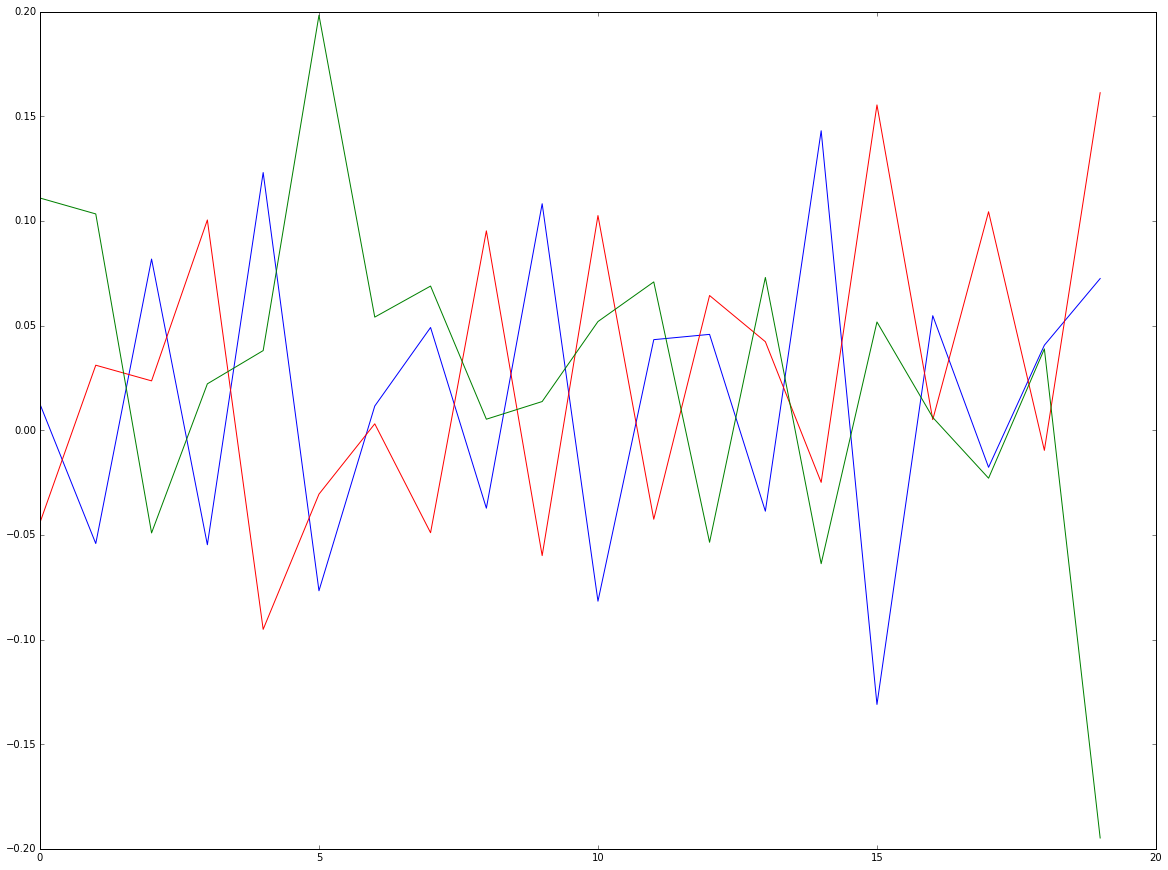

In [10]:
run_exp(test_seq, 100, 3, 20)

last delta is 0.0
iters was 47


array([[ 0.06901231, -0.02102908,  0.01305029, -0.02738824,  0.05941786,
        -0.07081632,  0.06558045, -0.01905229,  0.02394442,  0.00411435,
         0.01845259, -0.03120933,  0.13843794,  0.01962457,  0.10647049,
        -0.00675468,  0.00756944, -0.08557742,  0.00952796, -0.12970263,
         0.08843885,  0.05179589,  0.15776427,  0.07237222,  0.01983383,
        -0.0158593 ,  0.01035507, -0.18332086,  0.02849681, -0.03938946,
         0.05341948,  0.02524763,  0.0403155 , -0.03700467,  0.0288774 ,
        -0.05660284,  0.01176483, -0.01590477, -0.01810781, -0.03573331],
       [ 0.04219029,  0.07303998,  0.00907441, -0.01017717, -0.05386262,
        -0.04410907, -0.0249341 ,  0.06616597,  0.09200816,  0.05545069,
         0.0871168 ,  0.02587106, -0.12264934, -0.0621357 , -0.07348347,
         0.02557884,  0.06362361,  0.10676996,  0.06765464,  0.03597636,
        -0.05063211, -0.08669596, -0.06315446, -0.01513127,  0.07460376,
         0.05089166,  0.0524018 ,  0.04904781, -0.

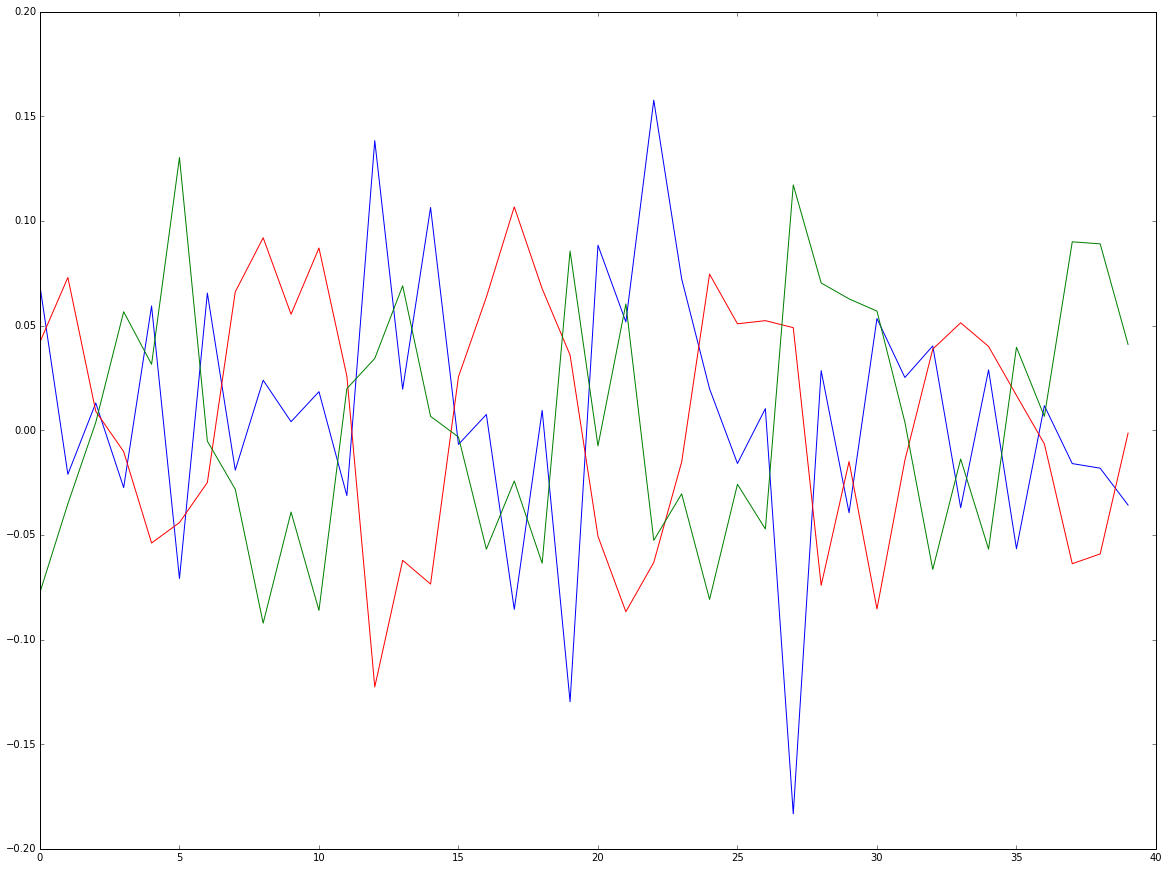

In [93]:
run_exp(test_seq, 100, 3, 40)

last delta is 0.0
iters was 5


array([[ 0.        ,  0.0999996 ,  0.1999992 ,  0.2999988 ,  0.39999839,
         0.49999799,  0.59999759,  0.69999719,  0.79999679,  0.89999639,
         0.99999598,  0.89999639,  0.79999679,  0.69999719,  0.59999759,
         0.49999799,  0.39999839,  0.2999988 ,  0.1999992 ,  0.0999996 ,
         0.        ],
       [ 0.99999598,  0.89999639,  0.79999679,  0.69999719,  0.59999759,
         0.49999799,  0.39999839,  0.2999988 ,  0.1999992 ,  0.0999996 ,
         0.        ,  0.0999996 ,  0.1999992 ,  0.2999988 ,  0.39999839,
         0.49999799,  0.59999759,  0.69999719,  0.79999679,  0.89999639,
         0.99999598]])

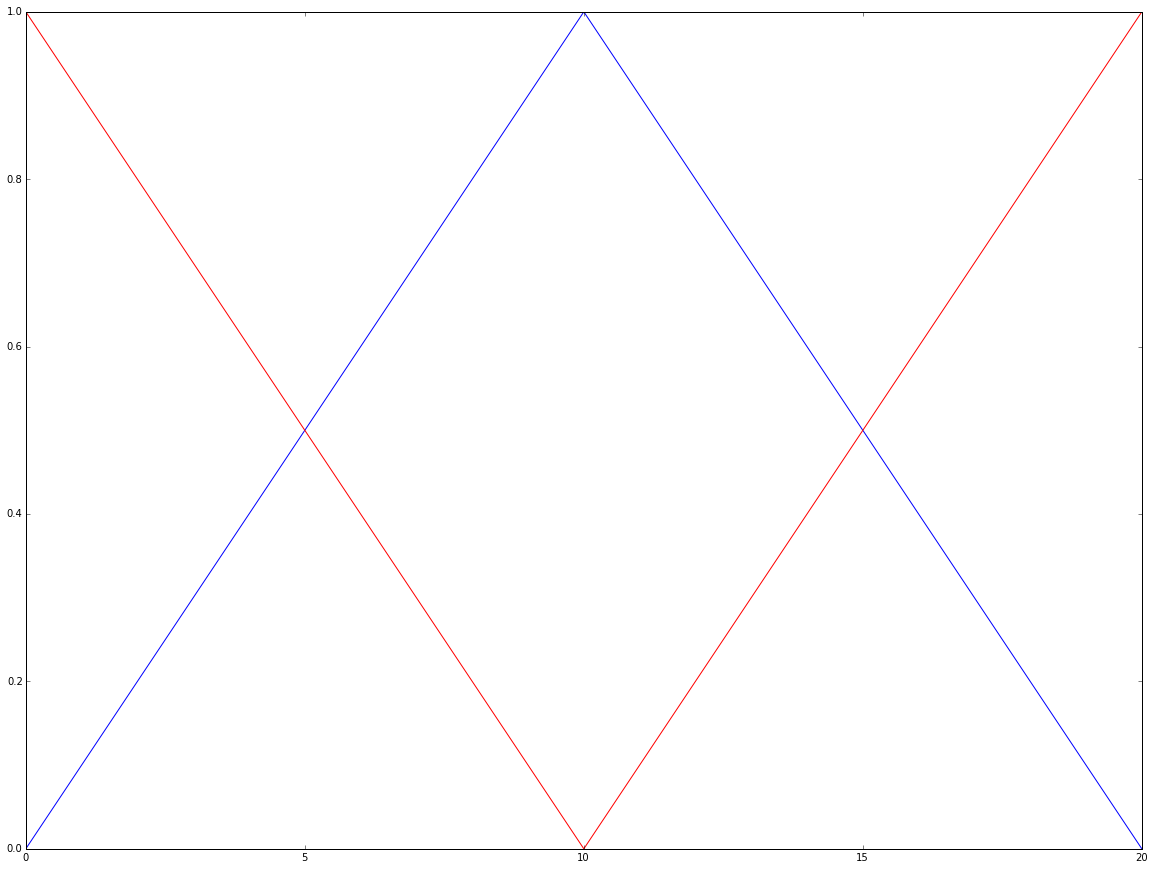

In [11]:
run_exp(square_wave_seq, 100, 2, 21)

last delta is 0.0
iters was 4


array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.14285632,  0.        ,  0.        ,  0.        ,  0.        ,
         0.14285632,  0.28571264,  0.42856896,  0.57142528,  0.7142816 ,
         0.85713792,  0.99999424,  0.99999424,  0.99999424,  0.99999424,
         0.85713792,  0.7142816 ,  0.57142528,  0.42856896,  0.28571264,
         0.14285632,  0.        ,  0.        ,  0.        ,  0.        ,
         0.14285632,  0.28571

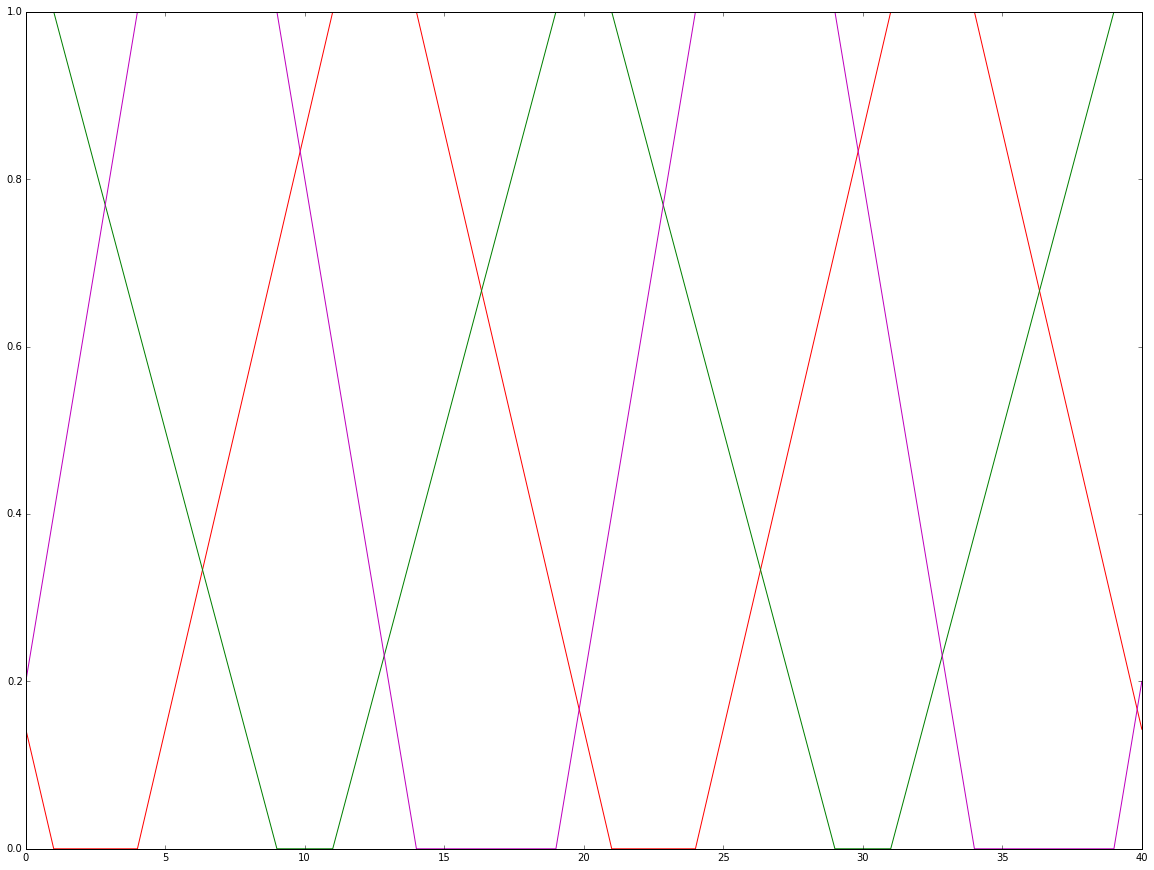

In [16]:
run_exp(square_wave_seq, 100, 5, 41)

last delta is 0.0
iters was 4


array([[  1.66666109e-01,   3.34670901e-04,   3.34670901e-04,
          3.34670901e-04,   1.66666109e-01,   4.16330601e-01,
          6.65995094e-01,   7.49328148e-01,   8.32661203e-01,
          7.49662819e-01,   6.66664436e-01,   5.00667668e-01,
          5.00667668e-01,   5.00667668e-01,   6.66999106e-01,
          7.49997490e-01,   8.32995874e-01,   7.49662819e-01,
          6.66329765e-01,   4.16330601e-01,   1.66666109e-01,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          1.67000780e-01,   4.16665272e-01,   6.66329765e-01,
          7.49662819e-01,   8.32995874e-01,   7.49328148e-01,
          6.65995094e-01,   4.99663656e-01,   4.99328985e-01,
          4.98994314e-01,   6.65660423e-01,   7.48993477e-01,
          8.32326532e-01,   7.49662819e-01,   6.66999106e-01,
          4.17334614e-01,   1.68004792e-01],
       [  4.29389039e-01,   5.72327369e-01,   7.14691649e-01,
          8.57629979e-01,   9.99994260e-01,   9.99994260e-01,
          9.99994260e-01,

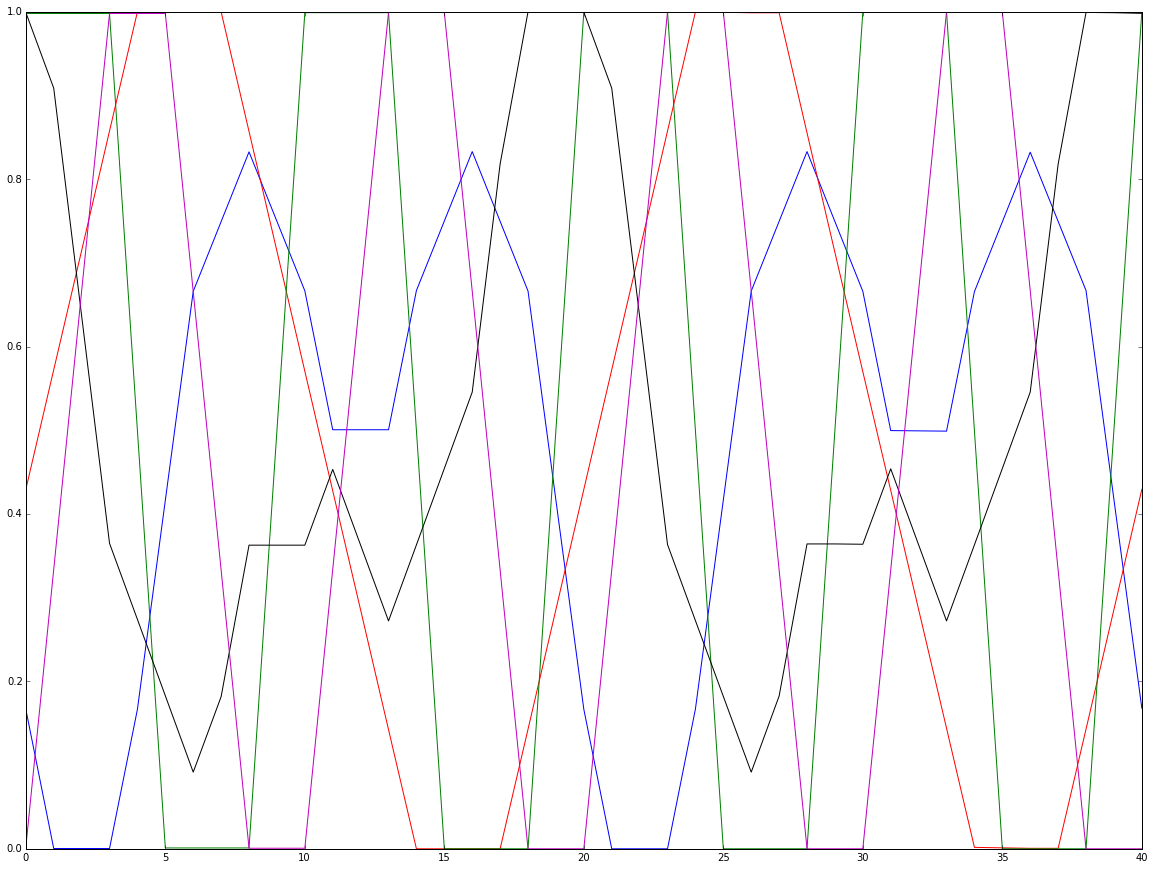

In [13]:
run_exp(np.concatenate([square_wave_seq, hi_freq_square_wave_seq]), 100, 5, 41)

last delta is 0.0
iters was 10


array([[-0.13326747, -0.33377374, -0.51352758, -0.66135276, -0.76805823,
        -0.82700955, -0.83454144, -0.79018557, -0.6966998 , -0.5598966 ,
        -0.38828175, -0.19252542,  0.01520121,  0.22198271,  0.41496239,
         0.58214172,  0.7131263 ,  0.79977214,  0.83669202,  0.82159044,
         0.75540635,  0.64225475,  0.48917086,  0.3056727 ,  0.10316929,
        -0.10574869, -0.30809173, -0.49127911, -0.64392114, -0.75652727,
        -0.8220962 , -0.83655117, -0.79899344, -0.71175817, -0.58026922,
        -0.41270195, -0.21947486, -0.01260189,  0.1950546 ,  0.39058355],
       [ 0.75971541,  0.80873708,  0.80747538,  0.75600878,  0.65753721,
         0.51818317,  0.346611  ,  0.15348825, -0.04917767, -0.24878595,
        -0.43292593, -0.59014867, -0.71067883, -0.78702242, -0.81443276,
        -0.79120562, -0.71878515, -0.6016741 , -0.44715387, -0.26483177,
        -0.06604372,  0.13685061,  0.33123623,  0.50502719,  0.647418  ,
         0.7495555 ,  0.80508927,  0.81056648,  0.

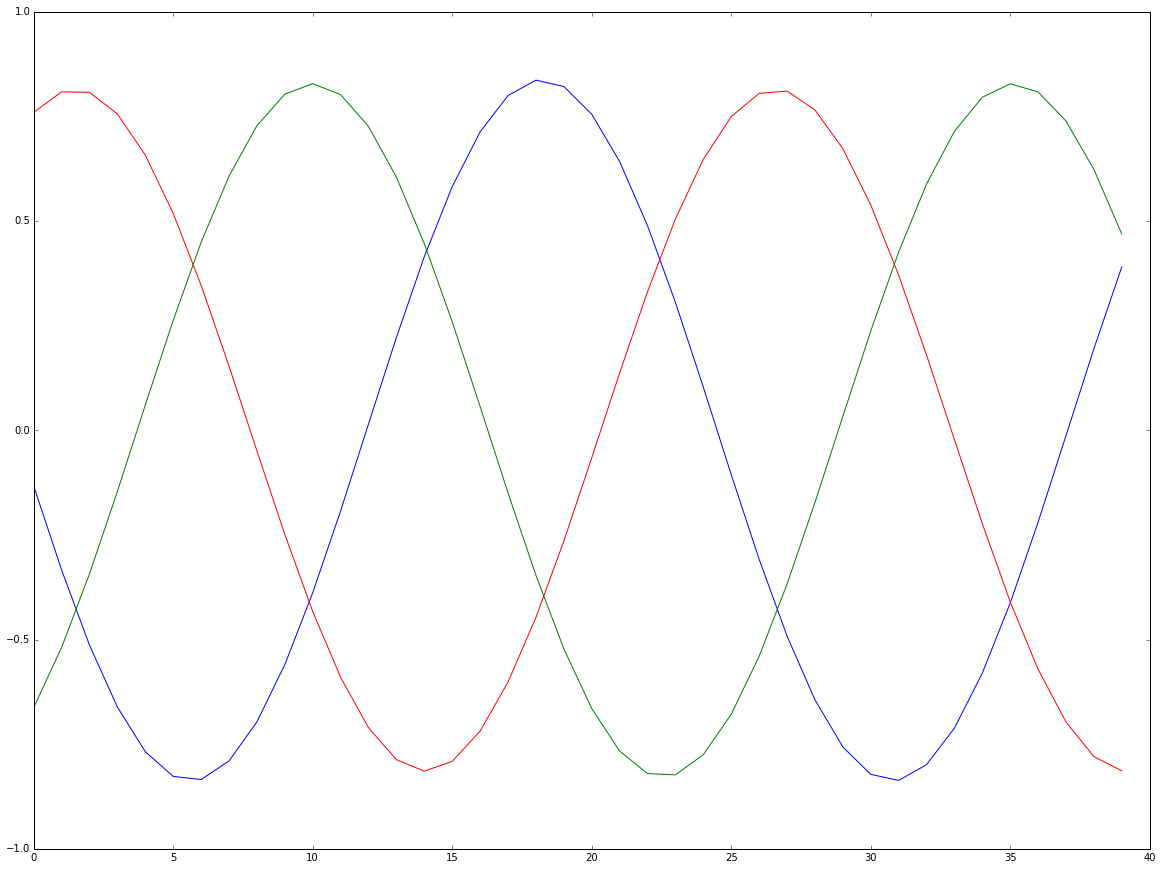

In [17]:
run_exp(sine_wave_seq, 100, 3, 40)

last delta is 0.0
iters was 10


array([[ 0.29158442,  0.08778019, -0.12148179, -0.32319062, -0.50480502,
        -0.65503309, -0.76453437, -0.82650061, -0.83707905, -0.79561196,
        -0.70467758, -0.56992975, -0.39974646, -0.20470887,  0.00305653,
         0.21063189,  0.40511118,  0.57440261,  0.70798048,  0.79753955,
         0.83751147,  0.82541098,  0.76199044,  0.65119302,  0.49990758,
         0.3175403 ,  0.1154299 , -0.09385736, -0.29730903, -0.48227547,
        -0.63725635, -0.75261572, -0.82118109, -0.8386894 , -0.80405206,
        -0.71942266, -0.59006304, -0.42401616, -0.23160601, -0.02479572],
       [-0.80579402, -0.74818943, -0.64406605, -0.49989777, -0.32464826,
        -0.12921369,  0.07425476,  0.2731064 ,  0.45497762,  0.60856052,
         0.72430609,  0.7950178 ,  0.81629917,  0.786827  ,  0.70843374,
         0.5859935 ,  0.42711903,  0.24168836,  0.04123068, -0.16179052,
        -0.35475237, -0.52565744, -0.66387968, -0.76082509, -0.81046608,
        -0.80971622, -0.75862212, -0.66036058, -0.

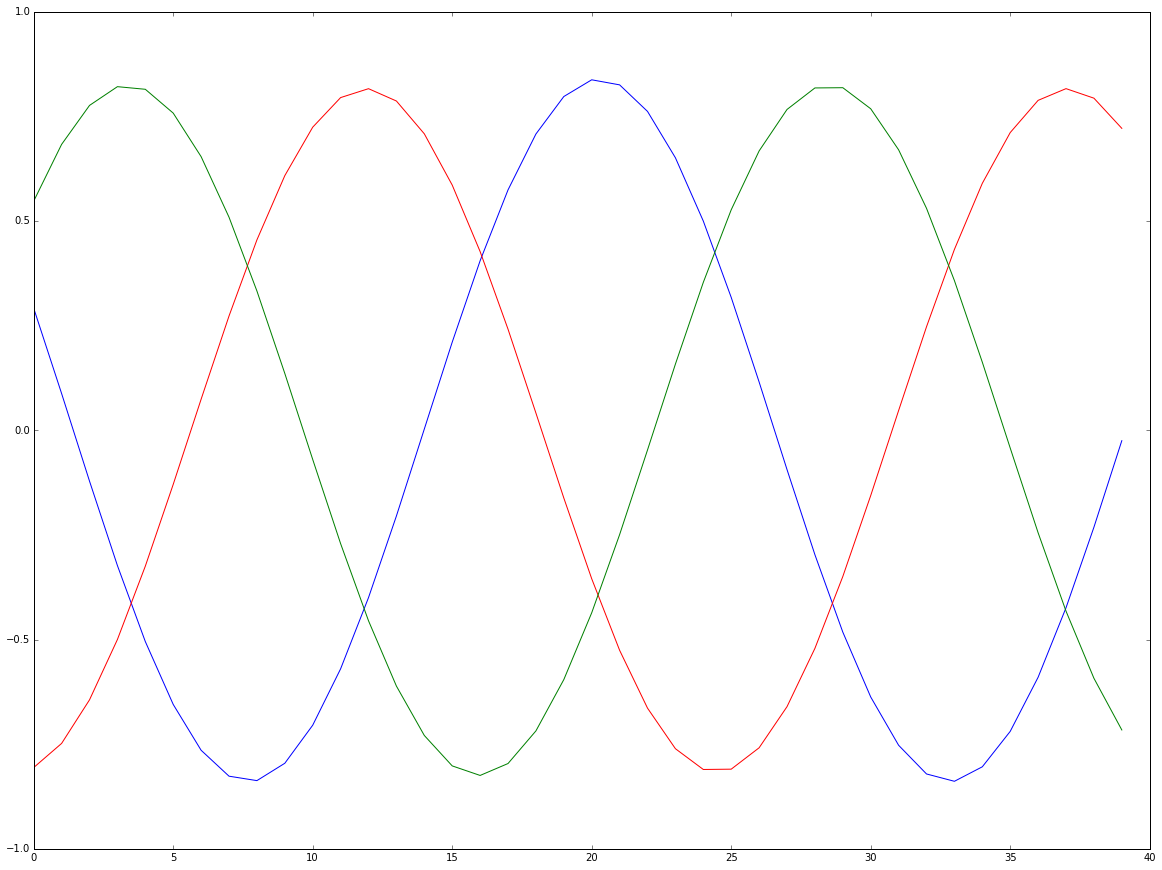

In [18]:
run_exp(sine_wave_seq, 100, 3, 40)

In [22]:
np.linalg.norm(np.ones(4))

2.0

In [26]:
arr = np.array(range(10)).reshape(5,2)
arr

array([[0, 1],
       [2, 3],
       [4, 5],
       [6, 7],
       [8, 9]])

In [36]:
closest(arr, [8,7.1])

4

In [29]:
np.dot(np.ones(3), np.ones(3))

3.0

In [30]:
np.argmax

<function numpy.core.fromnumeric.argmax>

In [32]:
np.argmax([1,15,3,2,9,7])

1

In [37]:
for i in arr:
    print i

[0 1]
[2 3]
[4 5]
[6 7]
[8 9]


In [74]:
np.max([1,2,3])

3